## Relativistic SGHMC "Relativistic Monte Carlo"

In this notebook we reproduce the results of the paper 
[Relativistic Monte Carlo](http://proceedings.mlr.press/v54/lu17b/lu17b.pdf#page=7).

We start by introducing and plotting all relevant log likelihoods of our objective functions.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tensorflow as tf
import numpy as np
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))

from pysgmcmc.diagnostics.objective_functions import (
    banana_log_likelihood, 
    gmm1_log_likelihood, gmm2_log_likelihood,
    gmm3_log_likelihood
)

from collections import namedtuple

ObjectiveFunction = namedtuple(
    "ObjectiveFunction", ["function", "dimensionality"]
)

objective_functions = (
    ObjectiveFunction(
        function=banana_log_likelihood, dimensionality=2
    ),
    ObjectiveFunction(
        function=gmm1_log_likelihood, dimensionality=1
    ),
    ObjectiveFunction(
        function=gmm2_log_likelihood, dimensionality=1
    ),
    ObjectiveFunction(
        function=gmm3_log_likelihood, dimensionality=1
    ),
)

def cost_function(log_likelihood_function):
    def wrapped(*args, **kwargs):
        return -log_likelihood_function(*args, **kwargs)
    wrapped.__name__ = log_likelihood_function.__name__
    return wrapped

#  Banana Contour {{{ #
def banana_plot():
    #x = np.arange(-30, 30, 0.05)
    #y = np.arange(-60, 20, 0.05)
    x = np.arange(-25, 25, 0.05)
    y = np.arange(-50, 20, 0.05)
    xx, yy = np.meshgrid(x, y, sparse=True)
    densities = np.asarray([np.exp(banana_log_likelihood((x, y))) for x in xx for y in yy])
    f, ax = plt.subplots(1)
    xdata = [1, 4, 8]
    ydata = [10, 20, 30]
    ax.contour(x, y, densities, 1, label="Banana")
    ax.plot([], [], label="Banana")
    ax.legend()
    ax.grid()
    #ax.set_ylim(ymin=-10, ymax=40)
    #ax.set_xlim(xmin=-6, xmax=7)
    ax.set_ylim(ymin=-60, ymax=20)
    ax.set_xlim(xmin=-30, xmax=30)
    
#  }}} Banana Contour #

#  Gaussian Mixture Models {{{ #

def gmm_plot(gmm_fun, label=None):
    xv = np.arange(-10, 10, 0.1)
    yv = np.asarray([np.exp(gmm_fun(xi)) for xi in xv])
    plt.grid()
    plt.plot(xv, yv, label=label)
    plt.legend()

plot_functions = {
    "banana_log_likelihood": banana_plot,
    "gmm1_log_likelihood": lambda: gmm_plot(gmm1_log_likelihood, label="GMM_1"),
    "gmm2_log_likelihood": lambda: gmm_plot(gmm2_log_likelihood, label="GMM_2"),
    "gmm3_log_likelihood": lambda: gmm_plot(gmm3_log_likelihood, label="GMM_3"),
}


def extract_samples(sampler, n_samples=1000, keep_every=10):
    from itertools import islice
    n_iterations = n_samples * keep_every
    return np.asarray(
        [sample for sample, _ in
         islice(sampler, 0, n_iterations, keep_every)]
    )

def plot_samples(sampler, n_samples=1000, keep_every=10):
    samples = extract_samples(
        sampler, n_samples=n_samples, keep_every=keep_every
    )
    plot_functions[sampler.cost_fun.__name__]()
    
    first_sample = samples[0]
    try:
        sample_dimensionality, = first_sample.shape
    except ValueError:
        plt.scatter(samples, np.exp([-sampler.cost_fun(sample) for sample in samples]))
    else:
        plt.scatter(*[samples[:, i] for i in range(sample_dimensionality)])

### Extract samples and plot them

Below we extract $1000$ samples for each cost function using relativistic sghmc and plot the samples on top of the respective function.

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


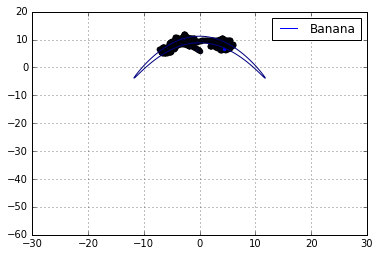

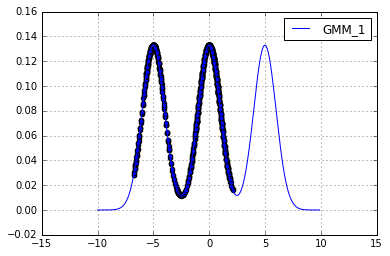

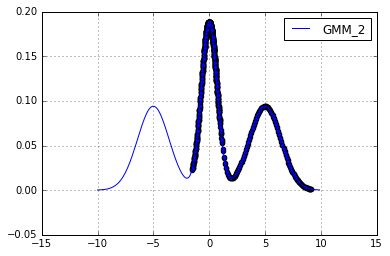

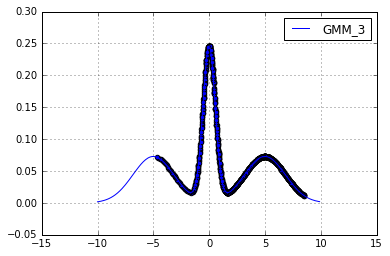

In [6]:
from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler

for function, dimensionality in objective_functions:
    tf.reset_default_graph()
    graph = tf.Graph()
    
    with tf.Session(graph=graph) as session:
        if function.__name__ == "banana_log_likelihood":
            params = [tf.Variable(0., dtype=tf.float32), tf.Variable(6., dtype=tf.float32)]
        else:
            params = [tf.Variable(0., dtype=tf.float32)]
        sampler = RelativisticSGHMCSampler(
            epsilon=0.01,
            params=params, 
            cost_fun=cost_function(function), 
            session=session,
            dtype=tf.float32
        )
        session.run(tf.global_variables_initializer())
    
        plot_samples(sampler)
        plt.show()

### Diagnostics

Next, we analyze some diagnostics of our relativistic sghmc sampler. Namely, we will study how effective sample sizes (ESS) and mean absolute error (MAE) behave and vary over different values for the stepsize $\epsilon$.